# Jax implementation of the Gaussian model

In [1]:
%load_ext autoreload
%autoreload 2
import site, sys, os, time
site.addsitedir('..')
from jax.config import config

#config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
import jax
from jax import random

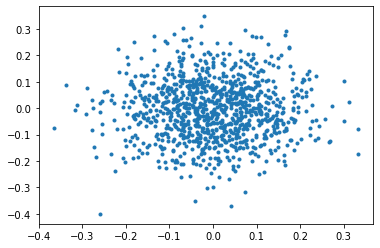

In [3]:
npt=1000
pts00=jnp.array(np.random.randn(npt,2))
pts00=pts00/(jnp.max(abs(pts00))*2.5)
plt.plot(pts00[:,0], pts00[:,1],'.')

In [4]:
#### size of image. memory usage scales with N^2 of this.
boxsz=sz=128

#### precompute Fourier indices 
idx=jnp.indices((boxsz,boxsz))-boxsz//2
idx=jnp.fft.ifftshift(idx)
idx=idx[:,:,:boxsz//2+1]
idxft=(idx/sz).astype(jnp.float32)[:, None, :,:]
rrft=jnp.sqrt(jnp.sum(idx**2, axis=0)).astype(jnp.float32)## batch, npts, x-y
amp=jnp.exp(-rrft*.1)


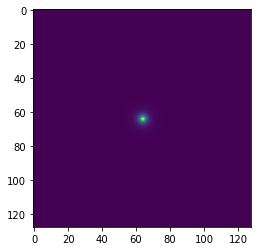

In [5]:
plt.imshow(jnp.fft.fftshift(jnp.fft.irfft2(amp)))

In [6]:
pts00[None,:,:].shape

(1, 1000, 2)

In [7]:
print(idxft.shape)

(2, 1, 128, 65)


In [8]:
sz

128

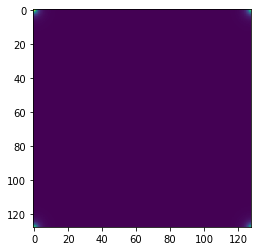

In [9]:
amp_r = jnp.fft.irfft2(amp)
amp_rx = amp_r[0]
amp_ry = amp_r[:,0]
plt.imshow(amp_r)
#plt.plot(amp_ry-amp_rx)

### Initial TensorFlow implementation, translated in JAX

(1, 128, 65)


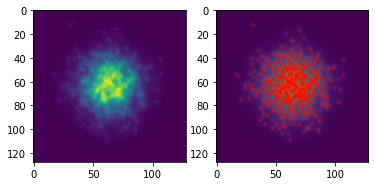

In [10]:
def pts2img(pts):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    bposft=bposft[:, :, :, None, None]
    
    ## this is the big 4d matrix for all Gaussian images
    ## (batchsz, # Gaussian, sz, sz//2+1)
    cpxang=idxft[0]*bposft[:,:,0] + idxft[1]*bposft[:,:,1]

    ## here we keep amplitude constand for simplification
    ## amp should be (sz, sz//2+1)
    pgauss_real=jnp.cos(cpxang)*amp
    pgauss_imag=-jnp.sin(cpxang)*amp
    
    imgs_real=jnp.sum(pgauss_real, axis=1)
    imgs_imag=jnp.sum(pgauss_imag, axis=1)

    return (imgs_real, imgs_imag)


imgs_real, imgs_imag=pts2img(pts00[None,:,:])#.astype(jnp.float32))
print(imgs_real.shape)
#imgs_cpx=np.complex(imgs_real, imgs_imag)
imgs_cpx = imgs_real + 1j*imgs_imag
imgs_out=jnp.fft.irfft2(imgs_cpx)

img0=imgs_out[0]
plt.subplot(1,2,1)
plt.imshow(img0)
#plt.colorbar()
p=pts00*sz+sz//2
plt.subplot(1,2,2)
plt.imshow(img0)
#plt.colorbar()
plt.plot(p[:,0], p[:,1],'.r', alpha=.2)

### Projection in real space

In [11]:
def gen_gauss_x(centre, x, sig, sz, amp):
    return jnp.exp(-(x-centre)**2/(2*sig**2)) * max_amp

gen_gauss_x_vmap = jax.vmap(gen_gauss_x, in_axes=(0, None,None,None,None))

def pts2img_one(pts):
    p_x = gen_gauss_x_vmap(pts[:,0], idx_r, sig, sz, max_amp)
    p_y = gen_gauss_x_vmap(pts[:,1], idx_r, sig, sz, max_amp) 
    return jnp.matmul(p_x.transpose(), p_y).transpose()

pts2img_vmap = jax.vmap(pts2img_one, in_axes=0)

Here we approximate the Gaussian in the real domain (it can be found exactly analytically).

0.0044154823
0.038066465


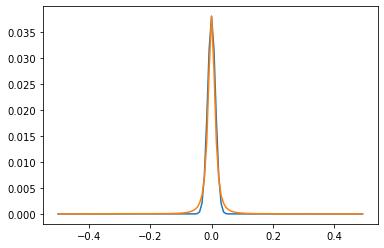

In [12]:
#print(p%pprint00.shape)
idx_r = jnp.arange(-sz/2, sz/2)/sz
#print(idx_r)
sig = 0.0129
centre = 0 #pts00[4,0] #0
max_amp = jnp.max(amp_rx)
gauss_x = gen_gauss_x(idx_r, centre, sig, sz, max_amp)
plt.plot(idx_r,gauss_x)
plt.plot(idx_r, jnp.fft.fftshift(amp_rx))
#plt.plot(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)    )
print(jnp.max(jnp.abs(jnp.fft.fftshift(amp_rx)-gauss_x)))
print(jnp.max(gauss_x))

Generate the image, adjust the scaling so it is the same as in the previous approach, then compare the images.

(128, 128)


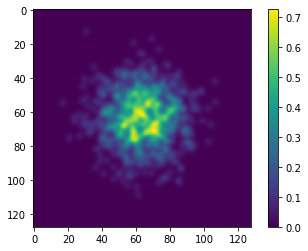

In [13]:
img1 = pts2img_one(pts00)
img1 = img1/jnp.max(img1)*jnp.max(img0)
print(img1.shape)
plt.imshow(img1);plt.colorbar()

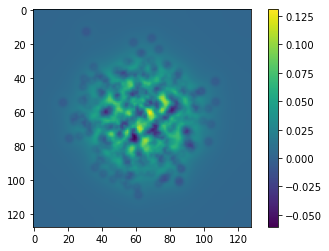

In [14]:
plt.imshow(img0-img1); plt.colorbar()

### Projection in Fourier space, memory-friendly

This implementation replicates the result of the TensorFlow implementation exactly (in single precision)

In [15]:
def mult_gauss_coords(centre, coords):
    return centre*coords

mult_gauss_coords_vmap = jax.vmap(mult_gauss_coords, in_axes=(0,None))

def pts2img2_one(pts, idxft):
    bpos=pts*sz+sz/2
    bposft=bpos*jnp.pi*2
    
    cpxang_x = mult_gauss_coords_vmap(bposft[:,0], idxft[0,0,:])   # 0 0 :
    cpxang_y = mult_gauss_coords_vmap(bposft[:,1], idxft[1,:,0])   # 1 : 0

    pgauss_x = jnp.exp(-1j*cpxang_x)
    pgauss_y = jnp.exp(-1j*cpxang_y)
  
    pgauss = jnp.matmul(pgauss_x.transpose(), pgauss_y).transpose() * amp
    
    return pgauss

1000.0
1000.0


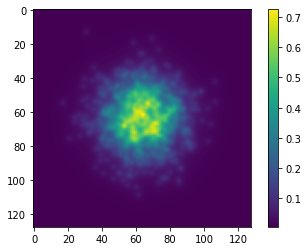

In [16]:
img_cpx2 = pts2img2_one(pts00, idxft[:,0,:,:])
print(jnp.max(jnp.real(img_cpx2)))

img2=jnp.fft.irfft2(img_cpx2)

print(jnp.max(jnp.real(img_cpx2)))

#plt.subplot(1,2,1)
plt.imshow(img2)
plt.colorbar()
#p=pts00*sz+sz//2
#plt.subplot(1,2,2)
#plt.imshow(img)
#plt.plot(p[:,0], p[:,1],'.r', alpha=.2)

Compare the two images

3.2802618e-07
0.726828


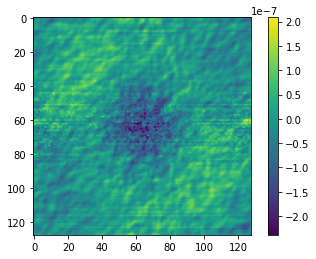

In [17]:
print(jnp.max(jnp.abs(img0-img2)/jnp.max(img0)))
print(jnp.max(img2))
plt.imshow(img0-img2); plt.colorbar()

### Loss functions

A basic squared L2 norm loss function, one for the TensorFlow approach and one for the last approach.

In [21]:
def loss_func(pts, img_f):
    imgs_real, imgs_imag=pts2img(pts)
    err_real = imgs_real - jnp.real(img_f)
    err_imag = imgs_imag - jnp.imag(img_f)
    return jnp.sum(err_real**2 + err_imag**2)

grad_loss = jax.grad(loss_func)

In [22]:
def loss_func_one(pts, img_f):
    proj_f = pts2img2_one(pts,idxft[:,0,:,:])
    err = proj_f - img_f
    return jnp.real(jnp.sum(jnp.conj(err)*err))

grad_loss_one = jax.grad(loss_func_one)

loss_func_vmap = jax.vmap(loss_func_one, in_axes = (None,0))

def loss_func_sum(pts, imgs_f):
    return jnp.mean(loss_func_vmap(pts, imgs_f))

def grad_loss_func_sum(pts, imgs_f):
    return jax.grad(loss_func_sum)(pts, imgs_f)

zero_img = jnp.zeros([sz, int(sz/2)+1])

In [24]:
t0 = time.time()
loss1 = loss_func(pts00[None,:,:], zero_img)
gp1 = grad_loss(pts00[None,:,:], zero_img)
print(time.time()-t0)

0.028066158294677734


In [26]:
t0 = time.time()
loss2 = loss_func_one(pts00, zero_img )
gp2 = grad_loss_one(pts00, zero_img)
print(time.time()-t0)

0.03623771667480469


The two approaches agree:

In [29]:
print((loss1-loss2)/jnp.max(jnp.abs(gp1)))
print(jnp.max(jnp.abs(gp1[0]-gp2))/jnp.max(jnp.abs(gp1)))

-7.286013e-06
5.6921976e-07


In [30]:
loss1

DeviceArray(4187124.8, dtype=float32)

In [31]:
loss2

DeviceArray(4187125.5, dtype=float32)

### Generate a batch of images to test the performance

(1000, 128, 65)


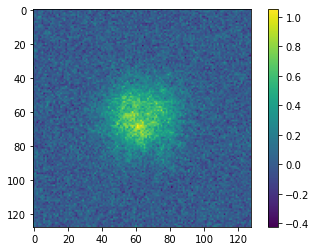

In [32]:
#### make some particle images for training later
##   they should stay in CPU as well
nptcl=1000
ptcls=0.1*np.random.randn(nptcl, sz,sz)+np.array(img2)
plt.imshow(ptcls[13]); plt.colorbar()
ptcls_f=np.fft.rfft2(ptcls)
#ptcls_real=jnp.real(ptcls_cpx).astype(jnp.float64)
#ptcls_imag=jnp.imag(ptcls_cpx).astype(jnp.float64)
print(ptcls_f.shape)

In [33]:
type(ptcls_f)

numpy.ndarray

In [34]:
print(jnp.max(img2))
print(jnp.max(ptcls[10]))

0.9957104
1.0687418


In [37]:
t0 = time.time()
loss2 = loss_func_one(pts00, ptcls_f[10])
gp2 = grad_loss_one(pts00, ptcls_f[10])
print(time.time()-t0)
print(gp2.shape)

0.03064107894897461
(1000, 2)


Apply the loss and the gradient functions to the batch of 1000 images.

In [42]:
t0 = time.time()
loss_sum = loss_func_sum(pts00, ptcls_f)
print(time.time() - t0)
print(loss_sum)

0.06393885612487793
1362737.2


In [43]:
t0 = time.time()
grad_loss = grad_loss_func_sum(pts00, ptcls_f)
print(time.time() - t0)
print(grad_loss.shape)

0.07689523696899414
(1000, 2)


Jax allocates all the available memory at the beginning, so the following does not tell us much (other than the total available memory, 8GB in this case)

In [44]:
os.system("nvidia-smi ");

Thu Mar 17 19:36:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 4000     On   | 00000000:3F:00.0 Off |                  N/A |
| 30%   40C    P8    11W / 125W |   7408MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Gradient descent on the Gaussian locations

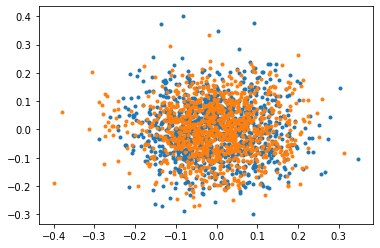

In [48]:
# Sample the initial points in the same way as the correct ones.

p0 = jnp.array(np.random.randn(npt,2))
p0 = p0/(jnp.max(abs(p0))*2.5)

plt.plot(pts00[:,0],pts00[:,1], '.')
plt.plot(p0[:,0],p0[:,1], '.')

In [49]:
N_iter = 1000
alpha = 1e-7

p = p0
for i in range(N_iter):
    gl = grad_loss_func_sum(p, ptcls_f)
    p = p - alpha * gl
    if jnp.mod(i,50)==0:
        print(i, jnp.linalg.norm(gl,2))


0 772035.3
50 19361.785
100 10806.805
150 7816.8384
200 6125.994
250 4882.66
300 3462.3354
350 2795.5845
400 2506.3086
450 2232.6155
500 1863.8872
550 1561.0448
600 1400.1941
650 1377.1317
700 1547.6
750 2080.751
800 2515.8247
850 2131.4463
900 2838.6926
950 1822.2383


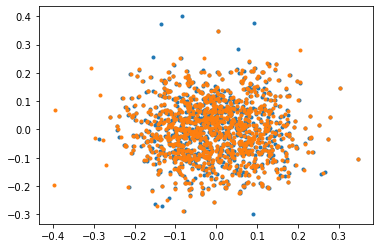

In [50]:
# Estimated Gaussian locations

plt.plot(pts00[:,0],pts00[:,1], '.')
plt.plot(p[:,0],p[:,1], '.')

In [52]:
ptcls_f.shape

(1000, 128, 65)